In [1]:
%load_ext autoreload
%autoreload 2

In [33]:
import torch
from druxai.models.fusion_model import FusionModel
from druxai.utils.data import DrugResponseDataset
from druxai.utils.dataframe_utils import split_data_by_cell_line_ids, standardize_molecular_data_inplace
from torch.utils.data import DataLoader
import pandas as pd
from scipy.stats import spearmanr
from druxai.utils.plotting import plot_ordered_r_scores

In [34]:
# Checkpoint path
# Always safe specific config with a run! Important especially if seed is changed because then we have other splits!

ckpt_path = "/Users/niklaskiermeyer/Desktop/Codespace/DruxAI/results/training/ckpt.pt"

checkpoint = torch.load(ckpt_path)
cfg = checkpoint["config"]

In [35]:
# Load data
data = DrugResponseDataset(cfg["DATA_PATH"])
train_id, val_id, test_id = split_data_by_cell_line_ids(data.targets)
standardize_molecular_data_inplace(data, train_id=train_id, val_id=val_id, test_id=test_id)

val_loader = DataLoader(
    data,
    sampler=val_id,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=6,
    persistent_workers=True
)

train_loader = DataLoader(
    data,
    sampler=train_id,
    batch_size=128,
    shuffle=False,
    pin_memory=True,
    num_workers=6,
    persistent_workers=True
)

INFO     Loaded targets with shape: (556840, 8)                                                                    
INFO     Loaded molecular data with shape: (1479, 19193)                                                           


In [36]:
config = {
    "metric": {"name": "r2_val", "goal": "maximize"},
    "resume": False,
    "patience": 5,
    "epochs": 10,
    "optimizer": "sgd",
    "scheduler": "exponential",
    "loss": "huber",
    "batch_size": 64,
    "learning_rate": 0.1,
    "output_features": 10,
    "hidden_dim": 64,
    "dropout_nn1": 0.2,
    "dropout_nn2": 0.2,
}

In [37]:
model = FusionModel(data, config["hidden_dim"], config["output_features"], config["dropout_nn1"], config["dropout_nn2"])

model.load_state_dict(checkpoint["model"])
model.to("mps")
# Setup optimizers

predictions = []
targets = []
cell_lines = []
drugs = []
keys = []
with torch.no_grad():
    model.eval()
    for X, y, idx in val_loader:
        drug, molecular, outcome = (
            X["drug_encoding"].to("mps"),
            X["gene_expression"].to("mps"),
            y.to("mps")
        )

        # Assuming model.predict returns the predicted values
        prediction = model.forward(drug, molecular).reshape(-1).tolist()
        predictions.append(prediction)

        targets.append(y.reshape(-1).tolist())

        # Fetch cell line and drug from data.targets DataFrame
        cell_line = data.targets.iloc[idx]["cell_line"].to_list()
        compound = data.targets.iloc[idx]["DRUG"].to_list()

        cell_lines.append(cell_line)
        drugs.append(compound)
        keys.append([id.item() for id in idx])

In [38]:
data_dict = {
    "ID": keys,
    "Prediction": predictions,
    "Target": targets,
    "cell_line": cell_lines,
    "Drug": drugs
}

# Create a DataFrame from the dictionary
results_df_val = pd.DataFrame(data_dict).apply(pd.Series.explode)

print(f"Overall R-Score: {spearmanr(results_df_val['Prediction'], results_df_val['Target'])[0]} \n")
print(results_df_val.head())

Overall R-Score: 0.7925240327998505 

     ID Prediction    Target   cell_line         Drug
0   288   0.225629  0.111156  ACH-000011   CYTARABINE
0   691   0.260441  0.263327  ACH-000011   EPINASTINE
0  1130  -0.495523 -0.525836  ACH-000011  FLOXURIDINE
0  1588  -0.437634 -0.499355  ACH-000011   VALRUBICIN
0  2020   0.117349  0.111945  ACH-000011    ADAPALENE


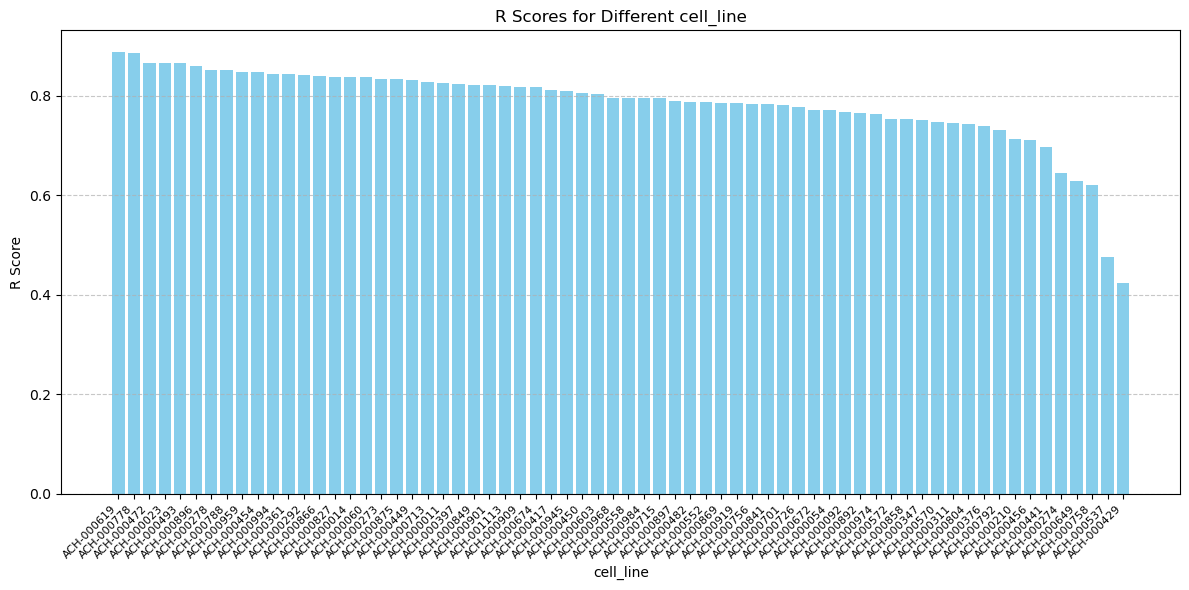

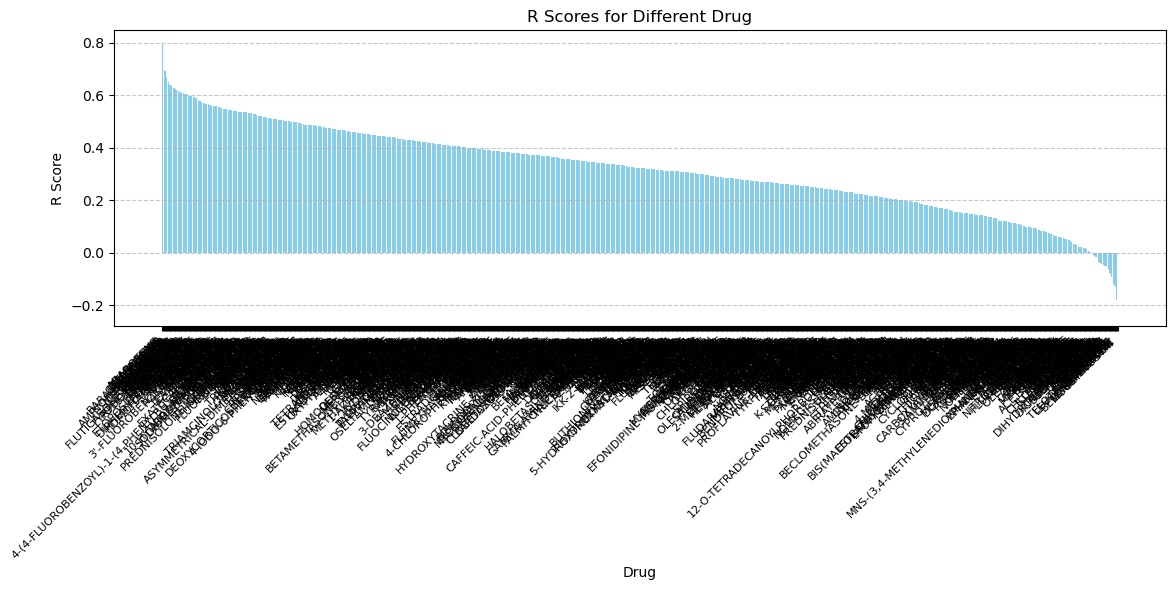

In [39]:
# Calculate R score for each cell line
group_by_features = ["cell_line", "Drug"]
grouped_dfs_val = {}
for group_by_feature in group_by_features:
    grouped_dfs_val[group_by_feature] = plot_ordered_r_scores(results_df_val, group_by_feature)

In [40]:
mean_r_score = {}
for key in grouped_dfs_val:
    mean_r_score[key] = grouped_dfs_val[key]["R Score"].mean()

print("Mean R Score stratified by Cell Line and Drug")
mean_r_score

Mean R Score stratified by Cell Line and Drug


{'cell_line': 0.784500830733381, 'Drug': 0.3186214323435876}

In [22]:
grouped_dfs_val["cell_line"]

,Group,R Score
32,ACH-000619,0.883829
42,ACH-000778,0.879742
23,ACH-000472,0.861557
2,ACH-000023,0.861178
25,ACH-000493,0.860959
...,...,...
8,ACH-000274,0.640448
33,ACH-000649,0.624714
41,ACH-000758,0.617706
26,ACH-000537,0.476608


In [23]:
grouped_dfs_val["Drug"]

,Group,R Score
42,ADAROTENE,0.771429
921,SAXAGLIPTIN,0.689420
1089,VALRUBICIN,0.681348
213,CCT128930,0.666893
67,AMINOPURVALANOL-A,0.661218
...,...,...
30,ABT-737,-0.098678
146,BETA-LAPACHONE,-0.100778
574,LCL-161,-0.153711
518,ILOMASTAT,-0.156787


## Prediction on Train set

In [25]:
model = FusionModel(data, config["hidden_dim"], config["output_features"], config["dropout_nn1"], config["dropout_nn2"])

model.load_state_dict(checkpoint["model"])
model.to("mps")
# Setup optimizers

predictions = []
targets = []
cell_lines = []
drugs = []
keys = []
with torch.no_grad():
    model.eval()
    for X, y, idx in train_loader:
        drug, molecular, outcome = (
            X["drug_encoding"].to("mps"),
            X["gene_expression"].to("mps"),
            y.to("mps")
        )

        # Assuming model.predict returns the predicted values
        prediction = model.forward(drug, molecular).reshape(-1).tolist()
        predictions.append(prediction)

        targets.append(y.reshape(-1).tolist())

        # Fetch cell line and drug from data.targets DataFrame
        cell_line = data.targets.iloc[idx]["cell_line"].to_list()
        compound = data.targets.iloc[idx]["DRUG"].to_list()

        cell_lines.append(cell_line)
        drugs.append(compound)
        keys.append([id.item() for id in idx])

Overall R-Score: 0.7772539128543056 

     ID Prediction    Target   cell_line             Drug
0   608   0.166934  0.184613  ACH-000008       EPINASTINE
0  1031  -0.540563 -0.528086  ACH-000008      FLOXURIDINE
0  1488  -0.467271 -0.449311  ACH-000008       VALRUBICIN
0  2335   0.163766  0.200556  ACH-000008  METHYLPHENIDATE
0  2735   0.036581  0.115816  ACH-000008      FULVESTRANT


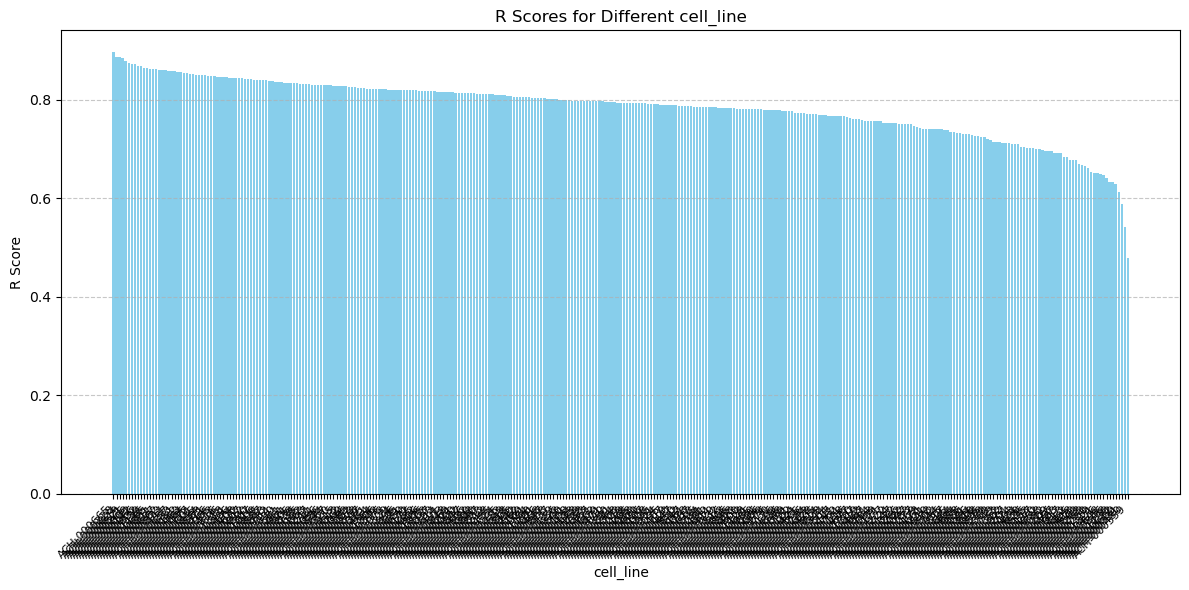

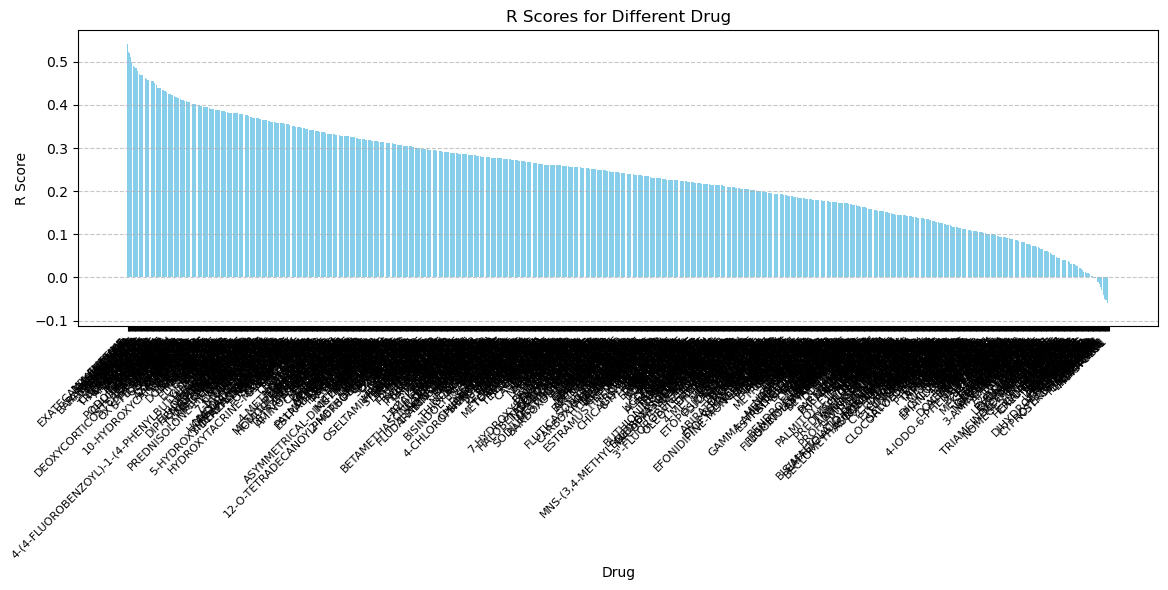

In [26]:
data_dict = {
    "ID": keys,
    "Prediction": predictions,
    "Target": targets,
    "cell_line": cell_lines,
    "Drug": drugs
}

# Create a DataFrame from the dictionary
results_df_train = pd.DataFrame(data_dict).apply(pd.Series.explode)

print(f"Overall R-Score: {spearmanr(results_df_train['Prediction'], results_df_train['Target'])[0]} \n")
print(results_df_train.head())

# Calculate R score for each cell line
group_by_features = ["cell_line", "Drug"]
grouped_dfs_train = {}
for group_by_feature in group_by_features:
    grouped_dfs_train[group_by_feature] = plot_ordered_r_scores(results_df_train, group_by_feature)

In [27]:
mean_r_score = {}
for key in grouped_dfs_train:
    mean_r_score[key] = grouped_dfs_train[key]["R Score"].mean()

mean_r_score

{'cell_line': 0.7844448726969844, 'Drug': 0.23876313108242675}

In [28]:
grouped_dfs_train["cell_line"]

,Group,R Score
194,ACH-000665,0.895923
56,ACH-000228,0.886148
254,ACH-000824,0.885605
253,ACH-000819,0.885136
152,ACH-000521,0.878417
...,...,...
205,ACH-000682,0.628356
174,ACH-000609,0.611738
91,ACH-000331,0.587241
138,ACH-000480,0.542520


In [29]:
grouped_dfs_train["Drug"]

,Group,R Score
357,EMETINE,0.541841
396,EXATECAN-MESYLATE,0.523110
672,MPI-0479605,0.520789
301,DANUSERTIB,0.510104
1085,UNC2250,0.498859
...,...,...
294,D-SERINE,-0.052599
791,PENTOSTATIN,-0.053436
361,ENOXIMONE,-0.059473
685,NAPROXEN,-0.061269


## Check Correlation between cell_lines type count vs predicted values

Is there a correlation between a cell_line which does not have many observation in terms of prediction vs highly presented ones
Same for drugs. 



In [30]:
val_cell_line_ranks = data.targets.iloc[val_id].groupby("cell_line")["DRUG"].nunique().sort_values().rank()
val_cell_line_ranks = pd.DataFrame(val_cell_line_ranks)

df1 = grouped_dfs_val["cell_line"].set_index("Group")
df2 = val_cell_line_ranks

merged_df = df1.join(df2)
correlation = merged_df["R Score"].corr(merged_df["DRUG"])

print("Val Correlation between R Score and rank:", correlation)

Val Correlation between R Score and rank: 0.3829104317396497


In [31]:
train_cell_line_ranks = data.targets.iloc[train_id].groupby("cell_line")["DRUG"].nunique().sort_values().rank()
train_cell_line_ranks = pd.DataFrame(train_cell_line_ranks)

df1 = grouped_dfs_train["cell_line"].set_index("Group")
df2 = train_cell_line_ranks

merged_df = df1.join(df2)
correlation = merged_df["R Score"].corr(merged_df["DRUG"])

print("Train Correlation between R Score and rank:", correlation)

Train Correlation between R Score and rank: 0.3169360496322918
